# Retail Data Wrangling and Analytics

In [8]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpg)

```
#make sure you have both Jupyter and PSQL docker container running
docker ps

#Attach a bridge network to both containers so they can communicate with each other
docker network create jarvis-net
#this command works on running containers
docker network connect jarvis-net jarvis-jupyter
docker network connect jarvis-net jarvis-psql

#verify both containers are attached to the jarvis-net
docker network inspect trading-net

#Note: instead of using `localhost`, you should use container names as hostnames.
```

**Data Preperation**

- Use [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame

![](https://i.imgur.com/AmkAP63.jpg)

- Get familair with the transaction date with `df.head()`, `df.sample(10)`, `df.info()`, `df.describe()`, etc..



# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [16]:
import os
import urllib.request

os.makedirs("data", exist_ok=True)

url = "https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv"
dest = "data/online_retail_II.csv"b

urllib.request.urlretrieve(url, dest)

os.listdir("data")


['grades.csv', 'online_retail_II.csv']

In [17]:
import pandas as pd

retail_df = pd.read_csv(
    "data/online_retail_II.csv",
    encoding="unicode_escape"
)

retail_df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [18]:
retail_df.info()
retail_df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


# Total Invoice Amount Distribution

In [20]:
# Step 2.0: Normalize column names to snake_case
retail_df.columns = (
    retail_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

retail_df.columns


Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country'],
      dtype='object')

In [22]:
# Step 2.1: Calculate invoice amount per row
retail_df["invoice_amount"] = retail_df["quantity"] * retail_df["price"]

retail_df[["invoice", "invoice_amount"]].head()


,invoice,invoice_amount
0,489434,83.4
1,489434,81.0
2,489434,81.0
3,489434,100.8
4,489434,30.0


In [23]:
# Step 2.2: Total invoice amount per invoice
invoice_totals = (
    retail_df
    .groupby("invoice")["invoice_amount"]
    .sum()
    .reset_index()
)

invoice_totals.head()


,invoice,invoice_amount
0,489434,505.30
1,489435,145.80
2,489436,630.33
3,489437,310.75
4,489438,2286.24


In [24]:
# Step 2.3: Invoice amount statistics
invoice_totals["invoice_amount"].describe()


count     53628.000000
mean        359.648888
std        1654.829288
min     -168469.600000
25%           0.000000
50%         196.345000
75%         403.652500
max      168469.600000
Name: invoice_amount, dtype: float64

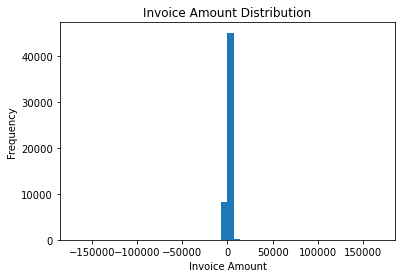

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(invoice_totals["invoice_amount"], bins=50)
plt.title("Invoice Amount Distribution")
plt.xlabel("Invoice Amount")
plt.ylabel("Frequency")
plt.show()


In [26]:
# Step 2.5: Distribution for first 85% of invoice amounts
q85 = invoice_totals["invoice_amount"].quantile(0.85)

invoice_85 = invoice_totals[invoice_totals["invoice_amount"] <= q85]

invoice_85["invoice_amount"].describe()


count     45583.000000
mean        136.977568
std        1071.983325
min     -168469.600000
25%           0.000000
50%         141.900000
75%         308.330000
max         594.000000
Name: invoice_amount, dtype: float64

# Monthly Placed and Canceled Orders

In [27]:
retail_df["invoicedate"] = pd.to_datetime(retail_df["invoicedate"])


In [28]:
retail_df["year_month"] = retail_df["invoicedate"].dt.to_period("M")

retail_df[["invoice", "invoicedate", "year_month"]].head()


,invoice,invoicedate,year_month
0,489434,2009-12-01 07:45:00,2009-12
1,489434,2009-12-01 07:45:00,2009-12
2,489434,2009-12-01 07:45:00,2009-12
3,489434,2009-12-01 07:45:00,2009-12
4,489434,2009-12-01 07:45:00,2009-12


In [29]:
monthly_orders = (
    retail_df
    .groupby("year_month")["invoice"]
    .nunique()
    .reset_index(name="order_count")
)

monthly_orders.head()


,year_month,order_count
0,2009-12,2330
1,2010-01,1633
2,2010-02,1969
3,2010-03,2367
4,2010-04,1892


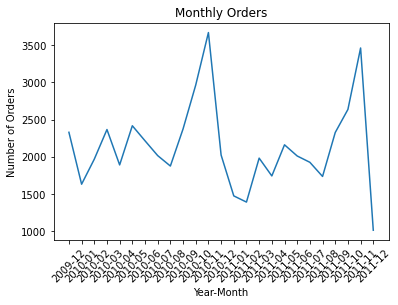

In [30]:
plt.figure()
plt.plot(monthly_orders["year_month"].astype(str),
         monthly_orders["order_count"])
plt.title("Monthly Orders")
plt.xlabel("Year-Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


# Monthly Sales

In [32]:
# Step 3.1: Calculate monthly sales amount
monthly_sales = (
    retail_df
    .groupby("year_month")["invoice_amount"]
    .sum()
    .reset_index(name="sales_amount")
)

monthly_sales.head()


,year_month,sales_amount
0,2009-12,799847.110
1,2010-01,624032.892
2,2010-02,533091.426
3,2010-03,765848.761
4,2010-04,590580.432


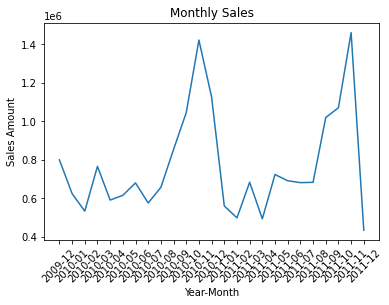

In [33]:
# Step 3.2: Plot monthly sales
plt.figure()
plt.plot(
    monthly_sales["year_month"].astype(str),
    monthly_sales["sales_amount"]
)
plt.title("Monthly Sales")
plt.xlabel("Year-Month")
plt.ylabel("Sales Amount")
plt.xticks(rotation=45)
plt.show()


# Monthly Sales Growth


In [34]:
# Step 4.1: Calculate monthly sales growth percentage
monthly_sales["sales_growth_pct"] = (
    monthly_sales["sales_amount"]
    .pct_change() * 100
)

monthly_sales.head()


,year_month,sales_amount,sales_growth_pct
0,2009-12,799847.110,NaN
1,2010-01,624032.892,-21.980978
2,2010-02,533091.426,-14.573185
3,2010-03,765848.761,43.661804
4,2010-04,590580.432,-22.885501


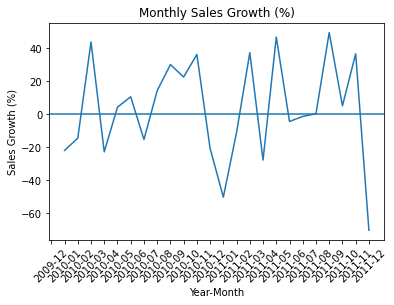

In [35]:
# Step 4.2: Plot monthly sales growth
plt.figure()
plt.plot(
    monthly_sales["year_month"].astype(str),
    monthly_sales["sales_growth_pct"]
)
plt.title("Monthly Sales Growth (%)")
plt.xlabel("Year-Month")
plt.ylabel("Sales Growth (%)")
plt.xticks(rotation=45)
plt.axhline(0)  # zero-growth reference line
plt.show()


# Monthly Active Users

In [36]:
# Step 5.1: Monthly Active Users (MAU)
monthly_active_users = (
    retail_df
        .groupby("year_month")["customer_id"]
        .nunique()
        .reset_index(name="active_users")
)

monthly_active_users.head()


,year_month,active_users
0,2009-12,1045
1,2010-01,786
2,2010-02,807
3,2010-03,1111
4,2010-04,998


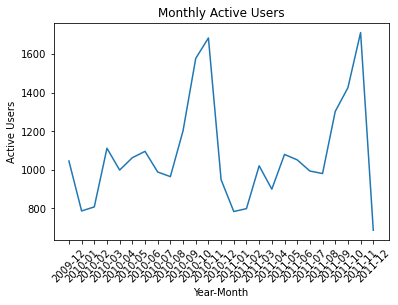

In [37]:
# Step 5.2: Plot Monthly Active Users
plt.figure()
plt.plot(
    monthly_active_users["year_month"].astype(str),
    monthly_active_users["active_users"]
)
plt.title("Monthly Active Users")
plt.xlabel("Year-Month")
plt.ylabel("Active Users")
plt.xticks(rotation=45)
plt.show()


# New and Existing Users



In [38]:
# Step 6.1: First purchase month per customer
first_purchase = (
    retail_df
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="first_purchase_month")
)

first_purchase.head()


,customer_id,first_purchase_month
0,12346.0,2009-12
1,12347.0,2010-10
2,12348.0,2010-09
3,12349.0,2009-12
4,12350.0,2011-02


In [39]:
# Step 6.2: Join first purchase info back to retail data
retail_with_first = retail_df.merge(
    first_purchase,
    on="customer_id",
    how="left"
)

retail_with_first[["customer_id", "year_month", "first_purchase_month"]].head()


,customer_id,year_month,first_purchase_month
0,13085.0,2009-12,2009-12
1,13085.0,2009-12,2009-12
2,13085.0,2009-12,2009-12
3,13085.0,2009-12,2009-12
4,13085.0,2009-12,2009-12


In [40]:
# Step 6.3: Classify users
retail_with_first["user_type"] = np.where(
    retail_with_first["year_month"] == retail_with_first["first_purchase_month"],
    "new",
    "existing"
)

retail_with_first[["customer_id", "year_month", "user_type"]].head()


,customer_id,year_month,user_type
0,13085.0,2009-12,new
1,13085.0,2009-12,new
2,13085.0,2009-12,new
3,13085.0,2009-12,new
4,13085.0,2009-12,new


In [41]:
# Step 6.4: Monthly new vs existing users
monthly_user_types = (
    retail_with_first
    .groupby(["year_month", "user_type"])["customer_id"]
    .nunique()
    .reset_index(name="user_count")
)

monthly_user_types.head()


,year_month,user_type,user_count
0,2009-12,existing,0
1,2009-12,new,1045
2,2010-01,existing,392
3,2010-01,new,394
4,2010-02,existing,444


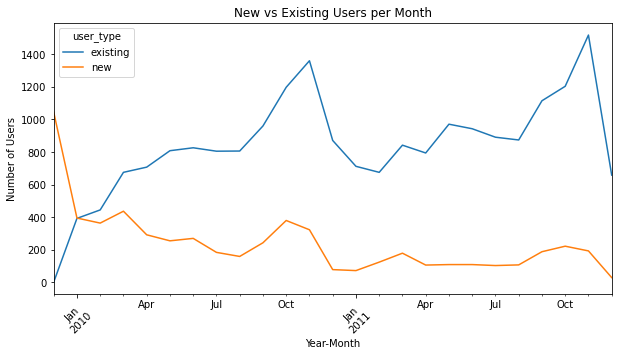

In [42]:
# Step 6.5: Plot new vs existing users
pivot_users = monthly_user_types.pivot(
    index="year_month",
    columns="user_type",
    values="user_count"
)

pivot_users.plot(figsize=(10,5))
plt.title("New vs Existing Users per Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.show()


## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

In [43]:
# Step 7.0: Define analysis date (last date in dataset)
analysis_date = retail_df["invoicedate"].max() + pd.Timedelta(days=1)

analysis_date


Timestamp('2011-12-10 12:50:00')

In [44]:
# Step 7.1: Calculate RFM metrics
rfm = (
    retail_df
    .groupby("customer_id")
    .agg(
        recency=("invoicedate", lambda x: (analysis_date - x.max()).days),
        frequency=("invoice", "nunique"),
        monetary=("invoice_amount", "sum")
    )
    .reset_index()
)

rfm.head()


,customer_id,recency,frequency,monetary
0,12346.0,326,17,-64.68
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,5,4404.54
4,12350.0,310,1,334.40


In [45]:
rfm.describe()


,customer_id,recency,frequency,monetary
count,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,202.908617,7.552339,2801.799459
std,1715.451981,211.857936,15.972262,13973.922553
min,12346.000000,1.000000,1.000000,-25111.090000
25%,13831.250000,25.000000,2.000000,325.097500
50%,15316.500000,96.000000,4.000000,843.970000
75%,16801.750000,381.000000,8.000000,2182.005000
max,18287.000000,739.000000,510.000000,598215.220000


In [46]:
# Step 7.3: Create RFM scores
rfm["R_score"] = pd.qcut(rfm["recency"], 5, labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["monetary"], 5, labels=[1,2,3,4,5])

rfm.head()


,customer_id,recency,frequency,monetary,R_score,F_score,M_score
0,12346.0,326,17,-64.68,2,5,1
1,12347.0,2,8,5633.32,5,4,5
2,12348.0,75,5,2019.40,3,3,4
3,12349.0,19,5,4404.54,4,3,5
4,12350.0,310,1,334.40,2,1,2


In [47]:
# Step 7.4: Combine RFM score
rfm["RFM_score"] = (
    rfm["R_score"].astype(str)
    + rfm["F_score"].astype(str)
    + rfm["M_score"].astype(str)
)

rfm.head()


,customer_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,12346.0,326,17,-64.68,2,5,1,251
1,12347.0,2,8,5633.32,5,4,5,545
2,12348.0,75,5,2019.40,3,3,4,334
3,12349.0,19,5,4404.54,4,3,5,435
4,12350.0,310,1,334.40,2,1,2,212


In [51]:
# Step 7.5: Segment customers
def rfm_segment(row):
    if row["R_score"] == 5 and row["F_score"] == 5 and row["M_score"] == 5:
        return "Champions"
    elif row["R_score"] >= 4 and row["F_score"] >= 4:
        return "Loyal"
    elif row["F_score"] >= 4:
        return "Frequent"
    elif row["M_score"] >= 4:
        return "Big Spenders"
    else:
        return "Others"


In [52]:
rfm["segment"] = rfm.apply(rfm_segment, axis=1)
rfm.head()


,customer_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,segment
0,12346.0,326,17,-64.68,2,5,1,251,Frequent
1,12347.0,2,8,5633.32,5,4,5,545,Loyal
2,12348.0,75,5,2019.40,3,3,4,334,Big Spenders
3,12349.0,19,5,4404.54,4,3,5,435,Big Spenders
4,12350.0,310,1,334.40,2,1,2,212,Others


In [53]:
# Step 7.6: Count customers per RFM segment
rfm_segment_counts = (
    rfm
    .groupby("segment")["customer_id"]
    .nunique()
    .reset_index(name="customer_count")
)

rfm_segment_counts


,segment,customer_count
0,Big Spenders,427
1,Champions,486
2,Frequent,899
3,Loyal,992
4,Others,3138


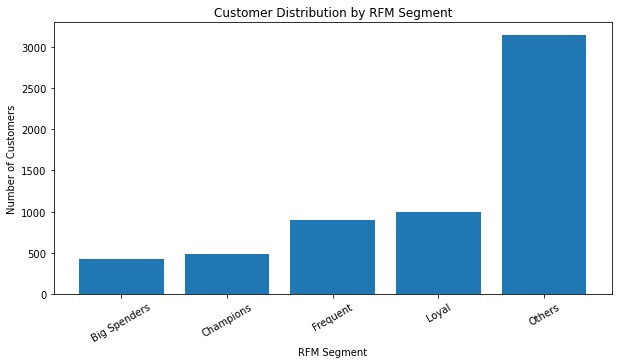

In [54]:
# Step 7.7: Plot RFM segmentation
plt.figure(figsize=(10, 5))
plt.bar(
    rfm_segment_counts["segment"],
    rfm_segment_counts["customer_count"]
)

plt.title("Customer Distribution by RFM Segment")
plt.xlabel("RFM Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()


# RFM Segmentation

In [ ]:
### RFM Segmentation Summary

RFM (Recency, Frequency, Monetary) segmentation is used to evaluate customer value and purchasing behavior.

- **Recency:** Number of days since the customers most recent purchase  
- **Frequency:** Number of unique purchases made by the customer  
- **Monetary:** Total amount spent by the customer  

Customers were scored on each dimension and combined into an overall RFM score, which was then used to classify customers into meaningful segments.

**Business Value:**
- Enables targeted marketing strategies for different customer groups
- Helps identify high-value customers (Champions and Loyal users)
- Supports retention, reactivation, and upselling decisions
- Improves customer lifetime value analysis

The RFM segmentation implemented above provides actionable insights for customer relationship management and marketing optimization.
